# ML generalization

This notebook gives an overview of the machine learning prediction of the pipeline. After all features are calculated, causal graph discovery is executed, only features with a direct causal link on the target are chosen in the ml modelling. The general training setup is that we conduct a 5-fold cross-validation per city and calculate shapley values. As we cannot share mobility data, we use again the sample data to demonstrate the prediction.

**Data availability:**  
The notebook uses a anonymized sample across all cities. All feature data can be downloaded as outlined in the manuscript section data availability.

**Questions or comments:**   
Feel free to open an issue in git or get in touch via wagner(at)mcc-berlin.de


# 0 Imports

In [2]:
import os, sys
import numpy as np
from matplotlib import pyplot as plt     
import sys
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split, KFold
from sklearn import model_selection
from sklearn import metrics
import shap


# import utils from xml4uf
PROJECT_SRC_PATH = os.getcwd().rsplit('/',1)[0]+'/xml4uf'
sys.path.append(PROJECT_SRC_PATH)

import utils.utils as utils
import utils.utils_ml as utils_ml
from utils.utils import FEATURE_NAMES, CITY_NAMES
from ml.ml import Predictor

# root path is defined by user, either here or in 
# bin/env_config.yml
path_root = utils.get_path_root()

/Users/felix/opt/miniconda3/envs/causal_env/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/felix/opt/miniconda3/envs/causal_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1 Load sample data

In [47]:
# load sample data:
# as we cannot share original data we take a preprocessed sample across all cities, 
# where all features + target are normalized to mean = 0 and standart dev = 1.
df = utils.load_pickle('sample_data.pkl')
df = df.iloc[964:1204].reset_index().drop(columns='index') # here we take samples from one city
df.head()

,tractid,distance_m,ft_dist_cbd,ft_employment_access_v2_05,ft_pop_dense,ft_income_groups,ft_beta
0,964,-0.529986,-0.917990,-0.812046,0.648013,-0.290637,0.785761
1,965,2.866949,1.305242,0.842094,-0.805875,-0.563942,-1.134255
2,966,-0.666229,-0.431416,-0.470313,-0.300311,1.130818,0.720306
3,967,-1.068140,-1.134564,-1.128470,1.792866,0.527339,0.001244
4,968,1.034281,0.722541,0.245442,-0.730526,0.458795,-0.941752


# 2 Initialize model and generalize
The ml pipeline executes the following steps. For each city:
1. initialize ml model
2. split data based on city names in train and test
3. tune hyperparameter
4. fit model & generalize



In [25]:
# define model parameters
model_name = 'XGBRegressor'
target = 'distance_m'
splitting_ratio = 0.8
folds = 5
eval_shap = ['causal_shap','tree_shap'] # evaluate causal and margnal/tree shap
causal_order = [[0],[1],[2],[3]] # causal order follows 1.'ft_dist_cbd', 2.'ft_employment_access_v2_05', 3.'ft_pop_dense', 4.'ft_beta']

# define hyperaparameters (note that we only allow few to minimize run time for this notebook)
HYPERPARAMS = {
            'learning_rate': [0.1,0.01,0.001],
            'n_estimators': [5000],
            'max_depth': [2],
            'colsample_bytree': [0.5],
            'colsample_bylevel': [0.5],
            }

# get feature names; exclude income feature as not direct causal effect 
# on vkt (see notbook dag_discovery.ipynb)
feature_names = [ft for ft in df.columns if ('ft' in ft)&('ft_income_groups' not in ft)] 
feature_names

['ft_dist_cbd', 'ft_employment_access_v2_05', 'ft_pop_dense', 'ft_beta']

In [26]:
model = Predictor(df,
				model_name,
				target, 
				feature_names,
				hyper_params = HYPERPARAMS,
                verbose=False)
model.select_model()
model.cv_fold(folds, eval_shap, causal_order)
model.results()

Optimizing Hyperparameters..
Fold 0: R2_train: 0.823, R2_test: 0.698
Determining shap values for ['ft_dist_cbd', 'ft_employment_access_v2_05', 'ft_pop_dense', 'ft_beta']...
Determining causal shap values for ['ft_dist_cbd', 'ft_employment_access_v2_05', 'ft_pop_dense', 'ft_beta']...


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
/Users/felix/opt/miniconda3/envs/causal_env/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/felix/opt/miniconda3/envs/causal_env/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/felix/opt/miniconda3/envs/causal_env/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/felix/opt/miniconda3/envs/causal_env/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' cur

Optimizing Hyperparameters..
Fold 1: R2_train: 0.837, R2_test: 0.749
Determining shap values for ['ft_dist_cbd', 'ft_employment_access_v2_05', 'ft_pop_dense', 'ft_beta']...


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Determining causal shap values for ['ft_dist_cbd', 'ft_employment_access_v2_05', 'ft_pop_dense', 'ft_beta']...


Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.003538414565592623' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Optimizing Hyperparameters..
Fold 2: R2_train: 0.843, R2_test: 0.660
Determining shap values for ['ft_dist_cbd', 'ft_employment_access_v2_05', 'ft_pop_dense', 'ft_beta']...


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Determining causal shap values for ['ft_dist_cbd', 'ft_employment_access_v2_05', 'ft_pop_dense', 'ft_beta']...


Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.028766391720452287' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Optimizing Hyperparameters..
Fold 3: R2_train: 0.846, R2_test: 0.517
Determining shap values for ['ft_dist_cbd', 'ft_employment_access_v2_05', 'ft_pop_dense', 'ft_beta']...


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Determining causal shap values for ['ft_dist_cbd', 'ft_employment_access_v2_05', 'ft_pop_dense', 'ft_beta']...


Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.08248472554363845' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Optimizing Hyperparameters..
Fold 4: R2_train: 0.865, R2_test: 0.424
Determining shap values for ['ft_dist_cbd', 'ft_employment_access_v2_05', 'ft_pop_dense', 'ft_beta']...


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Determining causal shap values for ['ft_dist_cbd', 'ft_employment_access_v2_05', 'ft_pop_dense', 'ft_beta']...


Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.01938748220656236' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [45]:
model.data.keys()
print('Prediction performance:')
print(f"R2 Train: {model.data['r2_model']:.2f}\nR2 Test:{model.data['r2_pred']:.2f}")

Prediction performance
R2 Train: 0.78
R2 Test:0.63


# 3 Analyse prediction via causal shapley values and marginal shapley values
Based on the 5-fold CV prediction within a city, we can now analyse the calculated shapley values. To better compare the difference, we compute beeswarm plots with causal (see 3.1) and marginal (3.2) shapley values.    

In such plots features are sorted on the y-axis according to their importance. For each feature its relative contribution is reported. The plot displays how a feature’s value (coloring) affects the prediction (x-axis) for every data point (each dot). If several dots fall onto the same position on the x-axis, i.e. have the same effect magnitude, they accumulate to show density.

## 3.1. Beeswarm plot with causal shapley values

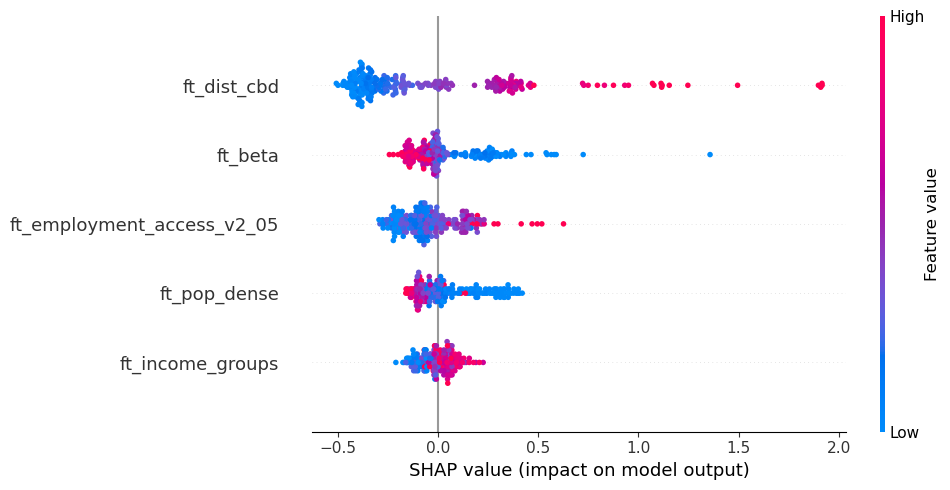

In [33]:
shap_type = 'causal_shap_test' # select computed causal shapley values

fig,axs = plt.subplots(figsize=(10,5))
explanation = model.data[shap_type]
shap.summary_plot(explanation, show =False, plot_size=None,plot_type="dot")

## 3.2. Beeswarm plot with marginal shapley values

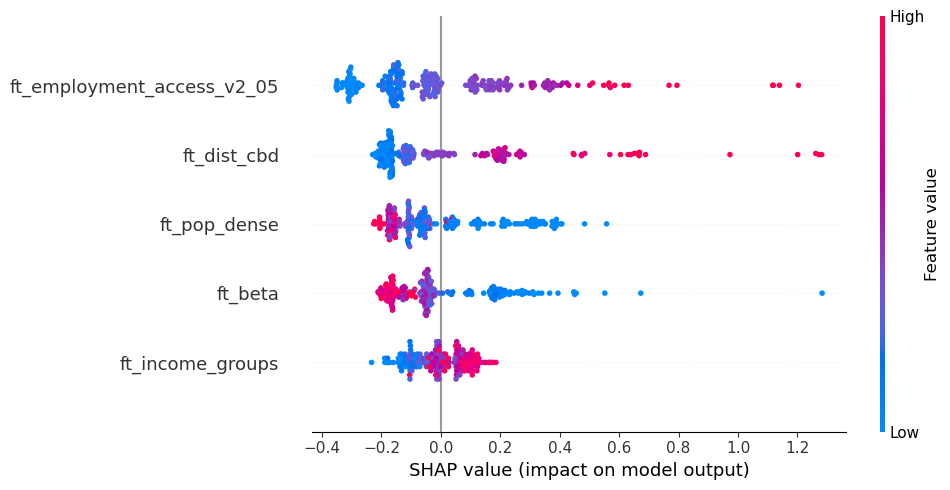

In [34]:
shap_type = 'shap_test'
fig,axs = plt.subplots(figsize=(10,5))
explanation = model.data[shap_type]
shap.summary_plot(explanation, show =False, plot_size=None,plot_type="dot")